### About

This project is about [a challenge from Kaggle](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/) to predict the demographic information of mobile users.

- [A reference notebook](https://www.kaggle.com/dvasyukova/talkingdata-mobile-user-demographics/brand-and-model-based-benchmarks)


### Data Description

In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

In [4]:
# list the data files
os.listdir('../data')

['gender_age_test.csv', 'gender_age_train.csv']

In [7]:
df_gender_age_train = pd.read_csv('../data/gender_age_train.csv')
df_gender_age_train.head()

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


In [9]:
df_gender_age_train.device_id.nunique?

In [12]:
len(df_gender_age_train)

74645

#### Group Distribution

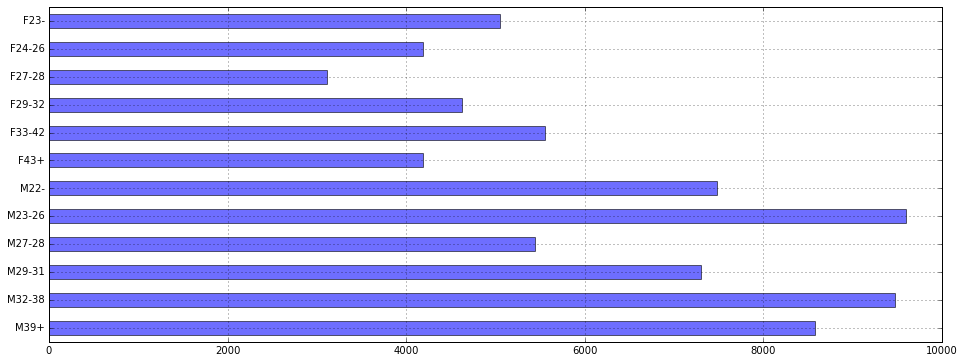

In [30]:
gender_age_group = df_gender_age_train.group.value_counts().sort_index(ascending=False)

def plot_horizontal_bar(data):
    ''' plot the data in horizontal bars. '''
    plt.figure()
    data.plot(kind='barh',color='b', alpha=0.57, grid=True, figsize=(16, 6))
    plt.show()

plot_horizontal_bar(gender_age_group)

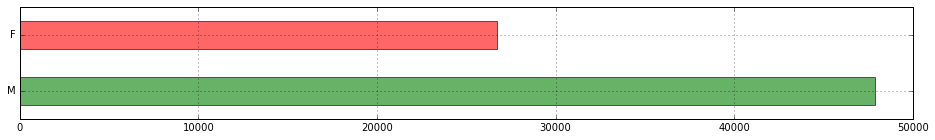

In [36]:
df_gender_age_train.gender.value_counts().plot(kind='barh',
    color=['g', 'r'], alpha=0.6, grid=True, figsize=(16, 2)
)

In [61]:
gender_age_dist = df_gender_age_train.groupby(['gender', 'age']).size()

age_range = np.arange(df_gender_age_train.age.min(),
                      df_gender_age_train.age.max())

gender_age_dist = gender_age_dist.unstack(level=0)

gender_age_dist = gender_age_dist.reindex(index=age_range).fillna(0)

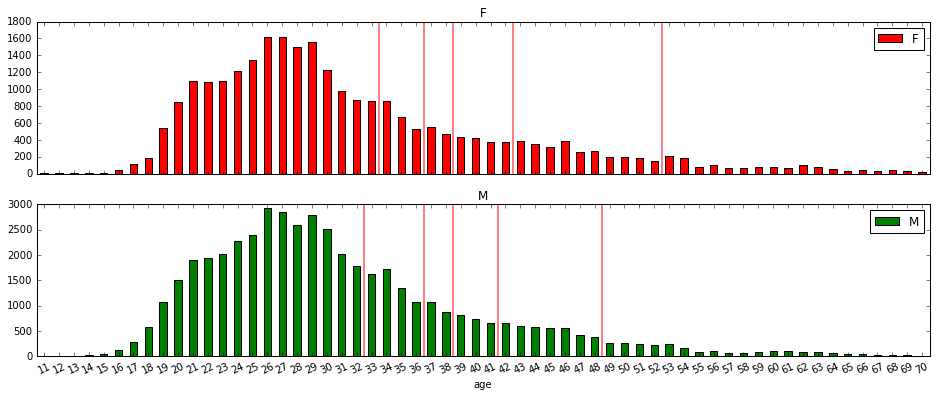

In [92]:
plt.figure()
ax1, ax2 = gender_age_dist.iloc[10:70].plot(kind='bar',
                                figsize=(16,6),
                                subplots=True,
                                color=['r', 'g'])
# xlabels = ['%i' % i for i in age_range]
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=25)

ax1.vlines(np.array([23,26,28,32,42])-0.5,0,1800,alpha=0.5,linewidth=2,color='r')
ax2.vlines(np.array([22,26,28,31,38])-0.5,0,3000,alpha=0.5,linewidth=2,color='r')
plt.show()